In [59]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from dgl.data.utils import load_graphs
import argparse 
import os
import pickle
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import networkx as nx
import dgl

class CNN(nn.Module):
    def __init__(self, conv_param, hidden_units):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=conv_param[0][0], out_channels=conv_param[1], kernel_size=conv_param[0][1], padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=conv_param[2])
        self.flatten = nn.Flatten()
        self.input_shape = conv_param[0][2]

        # Détermination de la taille de l'entrée des couches linéaires
        num_conv_features = self._calculate_conv_features(conv_param)
        self.linear_layers = self._create_linear_layers(num_conv_features, hidden_units)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)

        # Appliquer les couches linéaires
        for layer in self.linear_layers:
            x = layer(x)
            x = self.relu(x)
        return x

   
    def _calculate_conv_features(self, conv_param):
        # Calculer le nombre de caractéristiques extraites par les couches de convolution
        dummy_input = torch.zeros((1,conv_param[0][0], *self.input_shape))  # Exemple d'entrée (taille arbitraire)
        conv_output = self.conv1(dummy_input)
        conv_output = self.relu(conv_output)
        conv_output = self.pool(conv_output)
        conv_output = self.flatten(conv_output)
        return conv_output.size(1)
       

    def _create_linear_layers(self, num_conv_features, hidden_units):
        # Créer des couches linéaires en fonction du nombre de caractéristiques extraites par les couches de convolution
        layers = []
        for i in range(len(hidden_units)):
            if i == 0:
                layers.append(nn.Linear(num_conv_features, hidden_units[i]))
            else:
                layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
        return nn.ModuleList(layers)


# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, conv_param,hidden_units):
        super(GCN, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn = CNN(conv_param=conv_param, hidden_units=hidden_units)
        #self.conv1 = SAGEConv(hidden_units[-1], hidden_size, 'mean')
        self.conv1 = SAGEConv(in_feats, hidden_size, 'mean')
        self.conv2 = SAGEConv(hidden_size, num_classes, 'mean')

    def forward(self, g, features, edge_weights):
        #x = self.cnn(features.unsqueeze(1)).squeeze(1)
        x = self.flatten(features)
        x = F.relu(self.conv1(g, x, edge_weights))
        x = self.conv2(g, x, edge_weights)
        return x

# Define the training function
def train(model, g, features, labels, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        logits = model(g, features)
        print(logits)
        print(labels)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            


# Define a custom topological loss function
def topological_loss(embeddings, adj_matrix):
    # Calculate pairwise cosine similarity between embeddings
    cosine_sim = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    
    # Compute the reconstruction loss
    reconstruction_loss = F.mse_loss(cosine_sim, adj_matrix)
    
    return reconstruction_loss

# Define the training function with topological loss
def train_with_topological_loss(model, g, features, adj_matrix, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        embeddings = model(g, features)
        loss = topological_loss(embeddings, adj_matrix)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')





    
input_folder ='saved_graphs'



glist, label_dict = load_graphs(os.path.join(input_folder,"kws_graph.dgl"))
dgl_G = glist[0]  
features = dgl_G.ndata['feat']
labels = dgl_G.ndata['label']


# Initialize the GCN model
in_feats = in_feats = features[0].shape[0] * features[0].shape[1]
hidden_size = 64
num_classes = len(labels.unique())  # Number of unique labels
conv_param = [
    # Paramètres de la première couche de convolution
    (1, 3, (20,64)),  # Tuple: (nombre de canaux d'entrée, taille du noyau, forme de l'entrée)
    32,
    # Paramètres de la couche de pooling
    (2)
]

print(num_classes)
hidden_units = [32, 32]




6


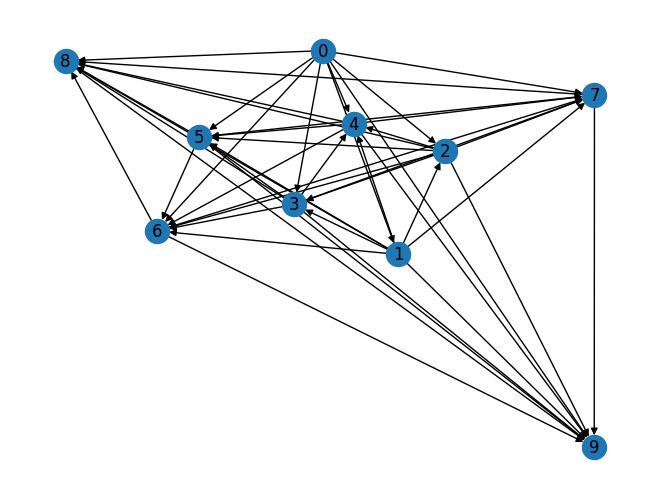

In [60]:
nx_graph = dgl_G.to_networkx()

# Plot the NetworkX graph
nx.draw(nx_graph, with_labels=True)
plt.show()

In [61]:
dgl_G.ndata['feat'].shape

torch.Size([10, 86, 64])

In [62]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

input_folder= 'models'
model_path = os.path.join(input_folder,"gnn_model.pth")
loaded_model = GCN(in_feats, hidden_size, num_classes, conv_param, hidden_units)
loaded_model.load_state_dict(torch.load(model_path))
edge_weights = dgl_G.edata['weight']

RuntimeError: Error(s) in loading state_dict for GCN:
	size mismatch for conv1.fc_neigh.weight: copying a param with shape torch.Size([64, 7936]) from checkpoint, the shape in current model is torch.Size([64, 5504]).
	size mismatch for conv1.fc_self.weight: copying a param with shape torch.Size([64, 7936]) from checkpoint, the shape in current model is torch.Size([64, 5504]).
	size mismatch for conv2.fc_neigh.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([6, 64]).
	size mismatch for conv2.fc_self.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([6, 64]).
	size mismatch for conv2.fc_self.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).

In [63]:
label_name ={0:'down', 1:'go', 2:'left', 3:'no', 4:'right', 5:'stop' ,6:'up', 7:'yes'}

import torch
import dgl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assurez-vous que votre modèle est en mode évaluation et que les gradients ne sont pas suivis
with torch.no_grad():
    loaded_model.eval()
    # Extraire les embeddings des nœuds du modèle
    node_embeddings = loaded_model(dgl_G, features, edge_weights).numpy()

# Réduire les dimensions pour le tracé avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Supposons que label_name soit un dictionnaire ou une liste de correspondance
# Par exemple, si label_name est un dictionnaire:
# label_name = {0: "Classe A", 1: "Classe B", 2: "Classe C"}
# Ou si c'est une liste:
# label_name = ["Classe A", "Classe B", "Classe C"]
# Assurez-vous que labels est une liste de labels numériques correspondant aux indices de label_name

# Convertir les labels numériques en labels textuels
text_labels = [label_name[label] for label in np.array(labels)]

# Obtenir les labels textuels uniques
unique_text_labels = list(set(text_labels))

# Créer un dictionnaire de couleurs pour chaque label textuel unique
colors = plt.cm.get_cmap("tab20", len(unique_text_labels))
label_color_map = {label: colors(i) for i, label in enumerate(unique_text_labels)}

# Tracer les représentations des nœuds
plt.figure(figsize=(10, 8))
for i, label in enumerate(text_labels):
    plt.scatter(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1], 
                color=label_color_map[label], alpha=0.7, edgecolors='w', s=100)

# Créer une légende sans doublons
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10, label=label) for label in unique_text_labels]
plt.legend(title='Labels', handles=handles)
plt.title('Node Representations (TSNE)')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.grid(True)
plt.show()


AssertionError: 

In [64]:
model_path = os.path.join(input_folder,"gnn_model_unsup.pth")
loaded_model = GCN(in_feats, hidden_size, num_classes, conv_param, hidden_units)
loaded_model.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for GCN:
	size mismatch for conv1.fc_neigh.weight: copying a param with shape torch.Size([64, 7936]) from checkpoint, the shape in current model is torch.Size([64, 5504]).
	size mismatch for conv1.fc_self.weight: copying a param with shape torch.Size([64, 7936]) from checkpoint, the shape in current model is torch.Size([64, 5504]).
	size mismatch for conv2.fc_neigh.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([6, 64]).
	size mismatch for conv2.fc_self.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([6, 64]).
	size mismatch for conv2.fc_self.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).

In [65]:
label_name ={0:'go' ,1:'down' , 2:'no' , 3:'yes' , 4:'left' , 5:'up', 6:'stop' , 7:'right'}
import torch
import dgl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assurez-vous que votre modèle est en mode évaluation et que les gradients ne sont pas suivis
with torch.no_grad():
    loaded_model.eval()
    # Extraire les embeddings des nœuds du modèle
    node_embeddings = loaded_model(dgl_G, features,edge_weights).numpy()

# Réduire les dimensions pour le tracé avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Supposons que label_name soit un dictionnaire ou une liste de correspondance
# Par exemple, si label_name est un dictionnaire:
# label_name = {0: "Classe A", 1: "Classe B", 2: "Classe C"}
# Ou si c'est une liste:
# label_name = ["Classe A", "Classe B", "Classe C"]
# Assurez-vous que labels est une liste de labels numériques correspondant aux indices de label_name

# Convertir les labels numériques en labels textuels
text_labels = [label_name[label] for label in np.array(labels)]

# Obtenir les labels textuels uniques
unique_text_labels = list(set(text_labels))

# Créer un dictionnaire de couleurs pour chaque label textuel unique
colors = plt.cm.get_cmap("tab20", len(unique_text_labels))
label_color_map = {label: colors(i) for i, label in enumerate(unique_text_labels)}

# Tracer les représentations des nœuds
plt.figure(figsize=(10, 8))
for i, label in enumerate(text_labels):
    plt.scatter(node_embeddings_2d[i, 0], node_embeddings_2d[i, 1], 
                color=label_color_map[label], alpha=0.7, edgecolors='w', s=100)

# Créer une légende sans doublons
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_map[label], markersize=10, label=label) for label in unique_text_labels]
plt.legend(title='Labels', handles=handles)
plt.title('Node Representations (TSNE)')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.grid(True)
plt.show()


AssertionError: 

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Supposons que vous avez déjà entraîné votre modèle GCN et que vous avez obtenu les représentations des données
# Vous avez également vos étiquettes dans la variable labels

# Obtenez les représentations des données à partir du modèle GCN
with torch.no_grad():
    loaded_model.eval()
    representations = loaded_model.cnn(features.unsqueeze(1)).squeeze(1).detach().numpy()
labels = data['label']
# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(representations, labels, test_size=0.2, random_state=42)

# Initialisez le classifieur SVM
svm_classifier = SVC()

# Entraînez le SVM sur les représentations
svm_classifier.fit(X_train, y_train)

# Prédisez les étiquettes sur l'ensemble de test
y_pred = svm_classifier.predict(X_test)

# Évaluez les performances du SVM en utilisant l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


NameError: name 'data' is not defined

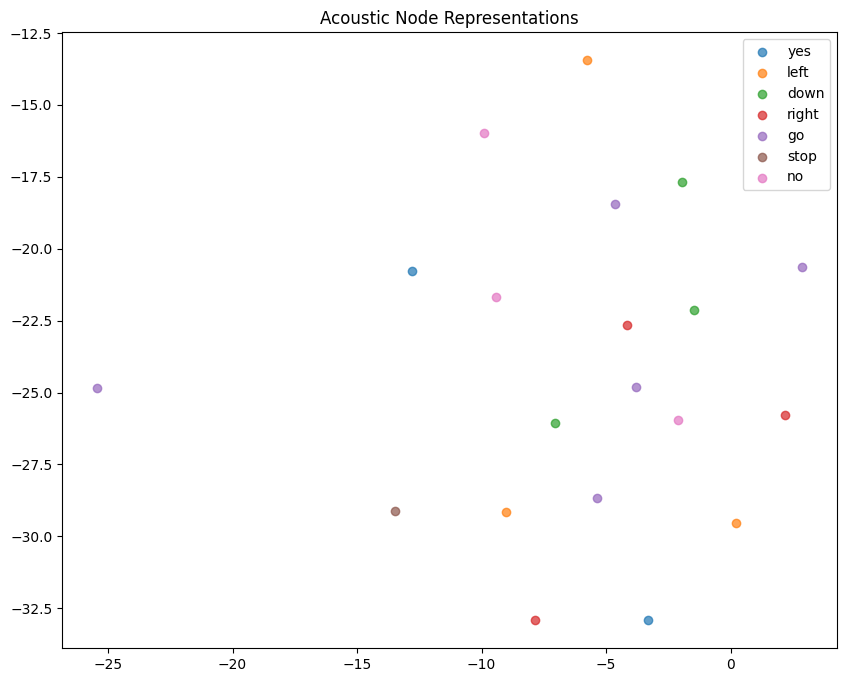

In [55]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import HeteroGraphConv, GraphConv, SAGEConv
import argparse 
import os
import networkx as nx

# Define the HeteroGCN model
class HeteroGCN(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(HeteroGCN, self).__init__()
        self.conv1 = HeteroGraphConv({
            'sim_tic': SAGEConv(in_feats['acoustic'], hidden_size, 'mean'),
            'sim_w': SAGEConv(in_feats['word'], hidden_size, 'mean'),
            'related_to': SAGEConv(in_feats['acoustic'], hidden_size, 'mean')
        }, aggregate='mean')
        self.conv2 = HeteroGraphConv({
            'sim_tic': SAGEConv(hidden_size, out_feats, 'mean'),
            'sim_w': SAGEConv(hidden_size, out_feats, 'mean'),
            'related_to': SAGEConv(hidden_size, out_feats, 'mean')
        }, aggregate='mean')

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(g, h)
        return h
# Function to load the model and graph, get representations, and plot them
def load_and_plot_model(input_folder, graph_file, model_file, label_name_file):
    # Load the heterogeneous graph
    glist, _ = dgl.load_graphs(os.path.join(input_folder, graph_file))
    hetero_graph = glist[0]

    # Load the model
    features = {
        'acoustic': hetero_graph.nodes['acoustic'].data['feat'],
        'word': hetero_graph.nodes['word'].data['feat']
    }
    in_feats = {'acoustic': features['acoustic'].shape[1], 'word': features['word'].shape[1]}
    hidden_size = 64
    out_feats = 16
    model = HeteroGCN(in_feats, hidden_size, out_feats)
    model.load_state_dict(torch.load(os.path.join(input_folder, model_file)))
    model.eval()

    # Get the acoustic node representations
    with torch.no_grad():
        embeddings = model(hetero_graph, features)
        acoustic_embeddings = embeddings['acoustic']

    # Load label names
    with open(os.path.join(input_folder, label_name_file), 'rb') as f:
        label_names = pickle.load(f)

    # Get labels and convert them to strings
    labels = hetero_graph.nodes['acoustic'].data['label']
    label_strings = [label_names[int(label)] for label in labels]

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2)
    acoustic_embeddings_2d = tsne.fit_transform(acoustic_embeddings)

    # Plot the acoustic node representations
    plt.figure(figsize=(10, 8))
    for label in set(label_strings):
        
          indices = [i for i, l in enumerate(label_strings) if l == label]
          plt.scatter(acoustic_embeddings_2d[indices, 0], acoustic_embeddings_2d[indices, 1], label=label, alpha=0.7)
    
    plt.legend()
    plt.title('Acoustic Node Representations')
    plt.show()

# Example usage
input_folder = ''
graph_file = 'saved_graphs/hetero_graph.dgl'
model_file = 'models/hetero_gnn_model.pth'
label_name_file = 'label_names.pkl'

load_and_plot_model(input_folder, graph_file, model_file, label_name_file)


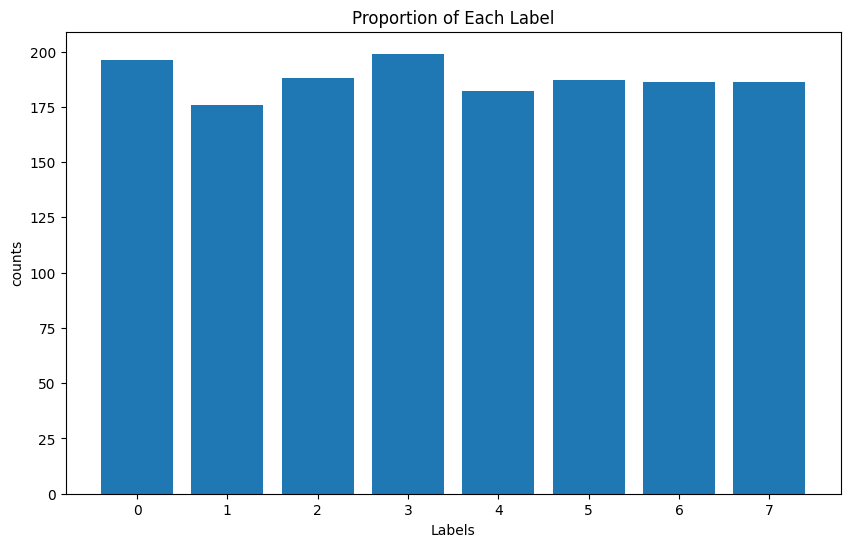

In [33]:
import torch
import matplotlib.pyplot as plt

# Assuming the tensor `labels` is already defined
# labels = tensor([1, 3, 2,  ..., 0, 3, 4])

# Count occurrences of each label
unique_labels, counts = torch.unique(labels, return_counts=True)

# Calculate proportions
proportions = counts.float() / counts.sum().float()

# Plotting the proportions
plt.figure(figsize=(10, 6))
plt.bar(unique_labels.numpy(), counts.numpy(), tick_label=unique_labels.numpy())
plt.xlabel('Labels')
plt.ylabel('counts')
plt.title('Proportion of Each Label')
plt.show()


In [31]:
len(labels)

1500

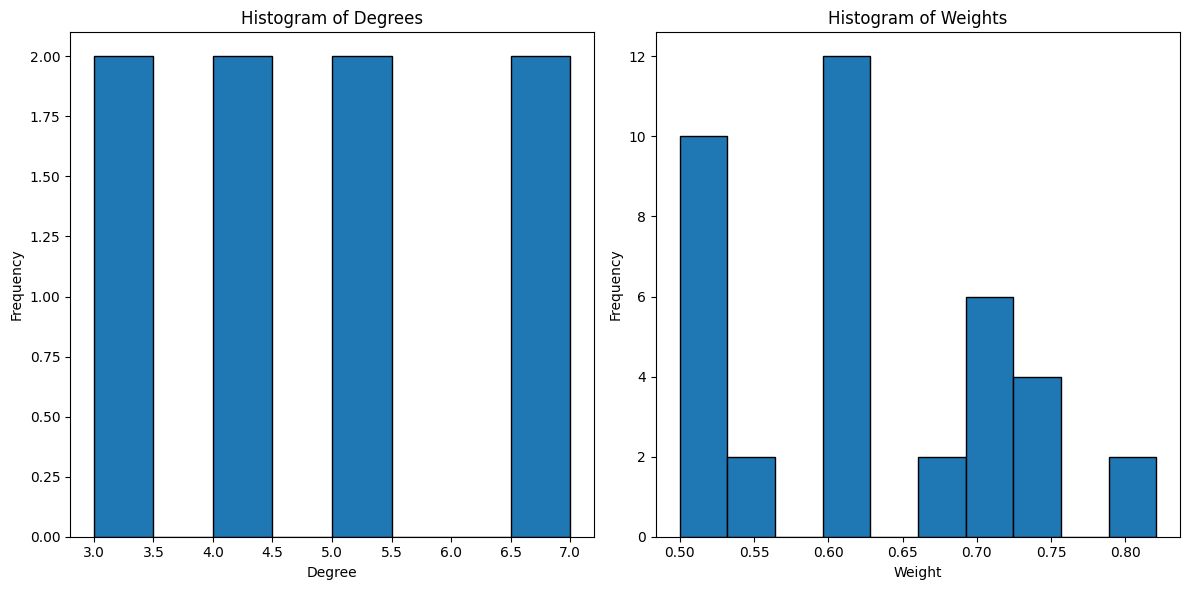

In [56]:
import torch
import matplotlib.pyplot as plt

# Assuming the adjacency matrix `adj_matrix` is already defined
# Example of an adjacency matrix (this is a weighted graph)
similarity_matrix = np.load('filtered_similarity_matrix_word.npy')
adj_matrix = similarity_matrix
# Calculate the degree of each node
# Calculate the degree of each node
degrees = np.count_nonzero(adj_matrix, axis=1)  # Sum of weights for each node (degree)

# Extract all edge weights (excluding zeros)
weights = adj_matrix[adj_matrix > 0]

# Plot histogram of degrees
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(degrees, bins=len(degrees), edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Degrees')

# Plot histogram of weights
plt.subplot(1, 2, 2)
plt.hist(weights, bins=10, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')

plt.tight_layout()
plt.show()


In [54]:
similarity_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

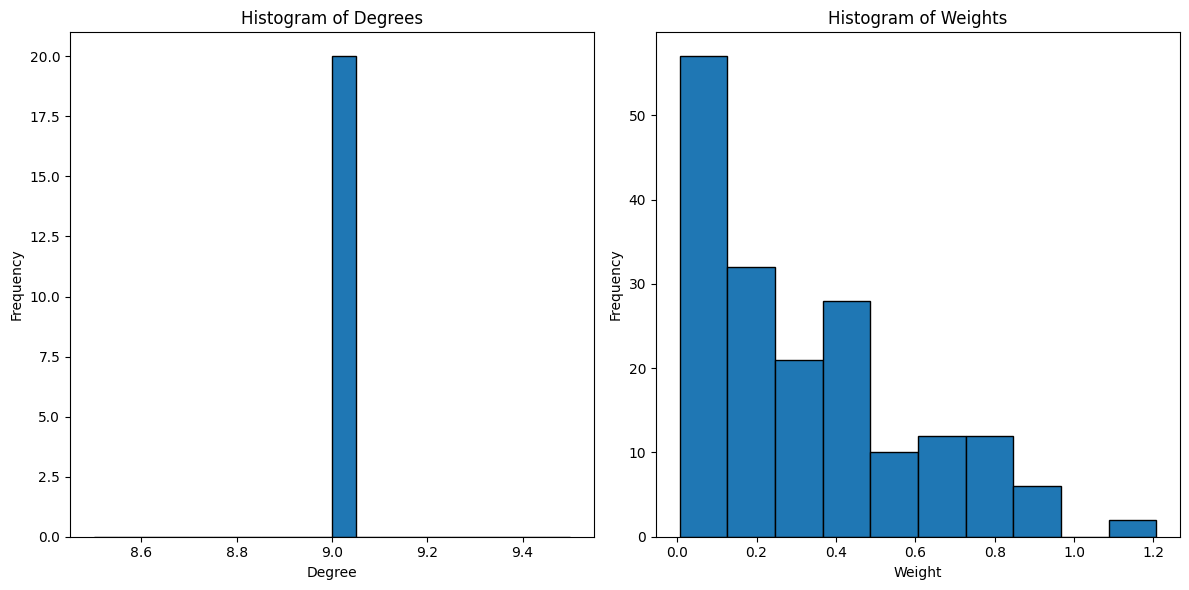

In [57]:
import torch
import matplotlib.pyplot as plt

# Assuming the adjacency matrix `adj_matrix` is already defined
# Example of an adjacency matrix (this is a weighted graph)
matrix_with_labels = np.load('filtered_similarity_matrix_with_labels.npy')

# Extract the labels and similarity matrix
similarity_matrix = matrix_with_labels[:, 1:]
adj_matrix = similarity_matrix
# Calculate the degree of each node
# Calculate the degree of each node
degrees = np.count_nonzero(adj_matrix, axis=1)  # Sum of weights for each node (degree)

# Extract all edge weights (excluding zeros)
weights = adj_matrix[adj_matrix > 0]

# Plot histogram of degrees
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(degrees, bins=len(degrees), edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Degrees')

# Plot histogram of weights
plt.subplot(1, 2, 2)
plt.hist(weights, bins=10, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')

plt.tight_layout()
plt.show()

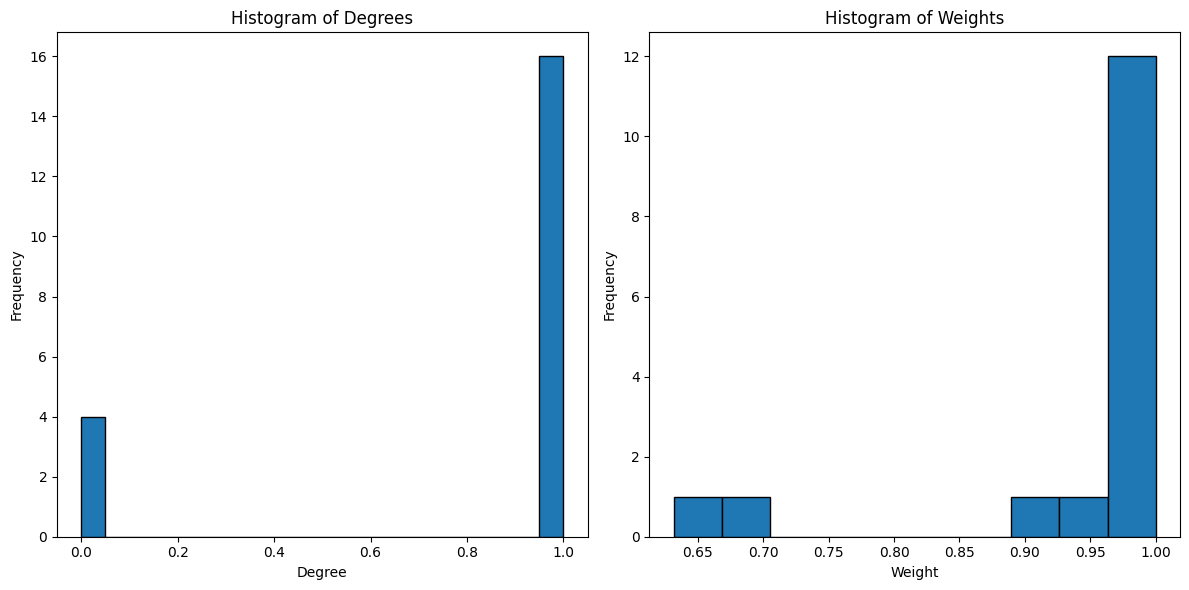

In [58]:
import torch
import matplotlib.pyplot as plt

# Assuming the adjacency matrix `adj_matrix` is already defined
# Example of an adjacency matrix (this is a weighted graph)
similarity_matrix = np.load('filtered_softmax_probabilities_words_acoustic.npy')
adj_matrix = similarity_matrix
# Calculate the degree of each node
# Calculate the degree of each node
degrees = np.count_nonzero(adj_matrix, axis=1) # Sum of weights for each node (degree)

# Extract all edge weights (excluding zeros)
weights = adj_matrix[adj_matrix > 0]

# Plot histogram of degrees
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(degrees, bins=len(degrees), edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Degrees')

# Plot histogram of weights
plt.subplot(1, 2, 2)
plt.hist(weights, bins=10, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weights')

plt.tight_layout()
plt.show()

In [44]:
similarity_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)